# Optimization of WWTP Gas Management - Comparison of different algorithms
All results are for a reduced dataset of 100 points. Only Numba-solution was applied to full dataset. See chapter [Results on full dataset](#results-on-full-dataset) for results thereof.  
**TOC**:  
[Load and preprocess data](#load-and-preprocess-data)  
[Regular optimization](#regular-optimization-by-ma-link)  
[Optimization with `.apply()` and Decorator Function](#optimization-with-apply-and-decorator-function-by-stackoverflowhttpsstackoverflowcomquestions16698415reference-previous-row-when-iterating-through-dataframe)  
[Optimization with `numba` compiled function](#optimization-with-numba-compiled-function-and-numpy-arrays)  
**Created by**: Jonas Miederer  
**Date**: 14.05.2022
## Import/Install Modules
**Note**: You may need to restart the kernel after installation!

In [16]:
try:
    import numpy as np
    import pandas as pd
    import time
    import matplotlib.pyplot as plt
    from numba import njit
    from scipy.optimize import dual_annealing
except:
    %conda install -q -y numpy pandas matplotlib numba scipy
    %conda install -c conda-forge time



## Load and preprocess data

In [17]:
df_root = pd.read_csv("data_gas_management.csv", skiprows= 1, sep=";", decimal=".",
                 names=['t', 'Gasspeichervolumen', 'Tendenz', 'Stromerzeugung_BHKW1'])


df_root['date_time'] = pd.to_datetime(df_root["t"], format="%d.%m.%Y %H:%M")
del df_root['t']
df_root = df_root[['date_time', 'Gasspeichervolumen', 'Tendenz', 'Stromerzeugung_BHKW1']]
df_root['diff_1'] = np.nan

# Stromerzeugung für ersten Zeitschritt übernehmen
df_root.loc[0, 'Stromerzeugung_BHKW1_calc'] = df_root.loc[0, 'Stromerzeugung_BHKW1']
df_root.head()


,date_time,Gasspeichervolumen,Tendenz,Stromerzeugung_BHKW1,diff_1,Stromerzeugung_BHKW1_calc
0,2020-01-01 00:15:00,2437.221223,0.000000,263.077806,NaN,263.077806
1,2020-01-01 00:30:00,2447.924388,10.703166,266.132219,NaN,NaN
2,2020-01-01 00:45:00,2509.910858,61.986470,266.523385,NaN,NaN
3,2020-01-01 01:00:00,2507.587378,-2.323481,264.047482,NaN,NaN
4,2020-01-01 01:15:00,2509.335328,1.747950,265.765657,NaN,NaN


## Regular optimization (by MA Link)

Regular optimization took 5.50s to compute
Ergebnisse BHKW 1:       fun: 12309.732319839735
 message: ['Maximum number of iteration reached']
    nfev: 380
    nhev: 0
     nit: 10
    njev: 113
  status: 0
 success: True
       x: array([1445.52246886,   96.19569997])


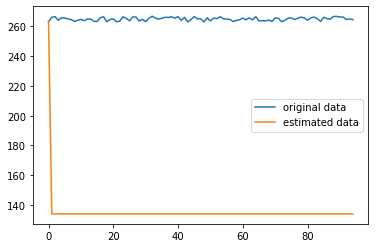

In [18]:
# Optimierung des kritischen Gasspeichervolumens sodass Stromerzegung möglichst realitätsnah
# Bedingungen für BHKWs definieren und kritischen Speicherstand optimieren
# obj1: Funktion die minimiert werden soll

df = df_root.copy()

def obj1(b1):
    x1, t1 = b1
    for i in range(1, len(df)):
        condition_SE_BHKW12 = [
            (df.loc[i, 'Gasspeichervolumen'] < x1) & (df.loc[i, 'Tendenz'] > t1) & (df.loc[i - 1, 'Stromerzeugung_BHKW1'] > 0),
            (df.loc[i, 'Gasspeichervolumen'] < x1),
            (df.loc[i, 'Gasspeichervolumen'] >= x1) & (df.loc[i, 'Gasspeichervolumen'] < 4500),
            (df.loc[i, 'Gasspeichervolumen'] >= 4500)
        ]
        values_SE_BHKW12 = [
            (x1 * 1.21e-4 + 0.455) * 851,
            0,
            (x1 * 1.21e-4 + 0.455) * 851,
            851
        ]
        df.loc[i, 'Stromerzeugung_BHKW1_calc'] = np.select(condition_SE_BHKW12, values_SE_BHKW12) / 4
    df['diff_1'] = df['Stromerzeugung_BHKW1_calc'] - df['Stromerzeugung_BHKW1']
    df['diff_1'] = df['diff_1'].abs()
    return df['diff_1'].sum()


# xmin1, xmax1: Grenzen innerhalb derer Funktion minimiert wird
xmin1 = 900
xmax1 = 1500
tmin1 = 0
tmax1 = 100
bounds1 = [[xmin1, xmax1], [tmin1, tmax1]]

# Start the stopwatch
tic1 = time.time()

result1 = dual_annealing(obj1, bounds=bounds1, maxiter=10, seed=42)

# Stop the stopwatch
toc1 = time.time()

print('Regular optimization took {:3.2f}s to compute'.format(toc1-tic1))

# Zusammenfassung der Ergebnisse für BHKW 1
print('Ergebnisse BHKW 1: ', result1)
sol_BHKW1 = result1['x']

plt.figure()
plt.plot(df['Stromerzeugung_BHKW1'], label="original data")
plt.plot(df['Stromerzeugung_BHKW1_calc'], label="estimated data")
plt.legend()

## Optimization with `.apply()` and Decorator Function (by [StackOverflow](https://stackoverflow.com/questions/16698415/reference-previous-row-when-iterating-through-dataframe))

Decorator optimization took 2.48s to compute
Ergebnisse BHKW 1:       fun: 12438.828695778477
 message: ['Maximum number of iteration reached']
    nfev: 296
    nhev: 0
     nit: 10
    njev: 85
  status: 0
 success: True
       x: array([1445.24938613,   31.34217815])


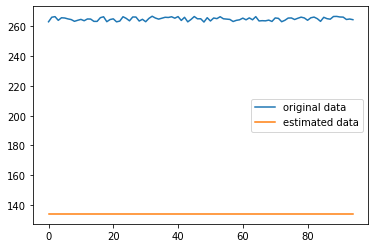

In [19]:
df = df_root.copy()

new_col = 'c'

def apply_func_decorator(func):
    prev_row = {}
    def wrapper(curr_row, **kwargs):
        val = func(curr_row, prev_row)
        prev_row.update(curr_row)
        prev_row[new_col] = val
        return val
    return wrapper



def obj1_wrapper(b1):
    x1, t1 = b1
    
    @apply_func_decorator  # Analog zu https://stackoverflow.com/questions/16698415/reference-previous-row-when-iterating-through-dataframe
    def loop_through_df(curr_row, prev_row):
        condition_SE_BHKW12 = [
            (curr_row['Gasspeichervolumen'] < x1) & (curr_row['Tendenz'] > t1) & (prev_row.get('Stromerzeugung_BHKW1', 0) > 0),
            (curr_row['Gasspeichervolumen'] < x1),
            (curr_row['Gasspeichervolumen'] >= x1) & (curr_row['Gasspeichervolumen'] < 4500),
            (curr_row['Gasspeichervolumen'] >= 4500)
        ]
        values_SE_BHKW12 = [
            (x1 * 1.21e-4 + 0.455) * 851,
            0,
            (x1 * 1.21e-4 + 0.455) * 851,
            851
        ]
        return np.select(condition_SE_BHKW12, values_SE_BHKW12) / 4

    df['Stromerzeugung_BHKW1_calc'] = df.apply(loop_through_df, axis = 1)
    df['diff_1'] = df['Stromerzeugung_BHKW1_calc'] - df['Stromerzeugung_BHKW1']
    df['diff_1'] = df['diff_1'].abs()
    return df['diff_1'].sum()


# xmin1, xmax1: Grenzen innerhalb derer Funktion minimiert wird
xmin1 = 900
xmax1 = 1500
tmin1 = 0
tmax1 = 100
bounds1 = [[xmin1, xmax1], [tmin1, tmax1]]

# Start the stopwatch
tic1 = time.time()

result1 = dual_annealing(obj1_wrapper, bounds=bounds1, maxiter=10, seed=42)

# Stop the stopwatch
toc1 = time.time()

print('Decorator optimization took {:3.2f}s to compute'.format(toc1-tic1))
print('Ergebnisse BHKW 1: ', result1)

plt.figure()
plt.plot(df['Stromerzeugung_BHKW1'], label="original data")
plt.plot(df['Stromerzeugung_BHKW1_calc'], label="estimated data")
plt.legend()

## Optimization with Numba-compiled function and NumPy arrays

Numba optimization took 0.51s to compute
Ergebnisse BHKW 1:       fun: 12589.077500577032
 message: ['Maximum number of iteration reached']
    nfev: 437
    nhev: 0
     nit: 10
    njev: 132
  status: 0
 success: True
       x: array([1438.7999267 ,   31.34217815])


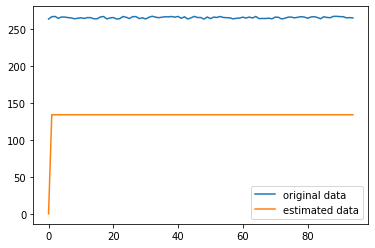

In [20]:
arr = df_root[['Gasspeichervolumen', 'Tendenz', 'Stromerzeugung_BHKW1', 'Stromerzeugung_BHKW1_calc', 'diff_1']].values

@njit
def apply_logic(arr, x1, t1):
    calc_arr= np.zeros(arr[:, 0].shape)
    for i in range(1, arr.shape[0]):
        # arr uses columns ['Gasspeichervolumen', 'Tendenz', 'Stromerzeugung_BHKW1', 'Stromerzeugung_BHKW1_calc', 'diff_1']
        if (arr[i, 0] < x1) & (arr[i, 1] > t1) & (arr[i-1, 2] > 0):
            calc_arr[i] = (x1 * 1.21e-4 + 0.455) * 851
        elif (arr[i, 0] < x1):
            calc_arr[i] = 0
        elif (arr[i, 0] >= x1) & (arr[i, 0] < 4500):
            calc_arr[i] = (x1 * 1.21e-4 + 0.455) * 851
        elif (arr[i, 0] >= 4500):
            calc_arr[i] = 851
    return calc_arr/4

@njit
def obj1_numba(b1):
    x1, t1 = b1
    # print(" Trying with " + str(x1) + " " + str(t1))
    calc_arr= np.zeros(arr[:, 0].shape)*1.5
    diff_arr = np.zeros(arr[:, 0].shape)*1.5

    calc_arr = apply_logic(arr, x1, t1)

    diff_arr = calc_arr - arr[:, 2]

    return np.absolute(diff_arr).sum()

# xmin1, xmax1: Grenzen innerhalb derer Funktion minimiert wird
xmin1 = 900
xmax1 = 1500
tmin1 = 0
tmax1 = 100
bounds1 = [[xmin1, xmax1], [tmin1, tmax1]]

# Start the stopwatch
tic2 = time.time()

result11 = dual_annealing(obj1_numba, bounds=bounds1, maxiter=10, seed=42)

# Stop the stopwatch
toc2 = time.time()

# Constuct the estimation array based on optimization
arr[:,3]=apply_logic(arr, result11.x[0], result11.x[1])


print('Numba optimization took {:3.2f}s to compute'.format(toc2-tic2))
print('Ergebnisse BHKW 1: ', result11)

plt.figure()
plt.plot(arr[:,2], label="original data")
plt.plot(arr[:,3], label="estimated data")
plt.legend()


### Results on full dataset:
```
Regular optimization with NumPy arrays (without @njit) took 34.71s to compute
Ergebnisse BHKW 1:       fun: 2073973.9317132381
 message: ['Maximum number of iteration reached']
    nfev: 656
    nhev: 0
     nit: 10
    njev: 205
  status: 0
 success: True
       x: array([1000.15805929,   16.92702695])

Numba optimization (with @njit) took 0.48s to compute
Ergebnisse BHKW 1:       fun: 2073974.4535927533
 message: ['Maximum number of iteration reached']
    nfev: 494
    nhev: 0
     nit: 10
    njev: 151
  status: 0
 success: True
       x: array([999.47997432,  16.92702695])
```
Rough comparison: ["Regular"](#regular-optimization-by-ma-link) algorithm took about 41 min to run on the complete dataset.  
--> only 0.2 % of computation time needed!